In [2]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import colormath

In [3]:
model_name = 'SNCWGAN/'
root = '/work3/s212645/Spectral_Reconstruction/checkpoint/'
metrics = 'metrics.pth'
path = root + model_name + metrics
result = torch.load(path, map_location=torch.device('cpu'))

In [4]:
MRAE = result['MRAE']
RMSE = result['RMSE']
PSNR = result['PSNR']
SAM = result['SAM']
length = len(MRAE)
for i in range(length):
    MRAE[i] = MRAE[i].item()
for i in range(length):
    RMSE[i] = RMSE[i].item()
for i in range(length):
    PSNR[i] = PSNR[i].item()
for i in range(length):
    SAM[i] = SAM[i].item()


Text(0.5, 1.0, 'SAM')

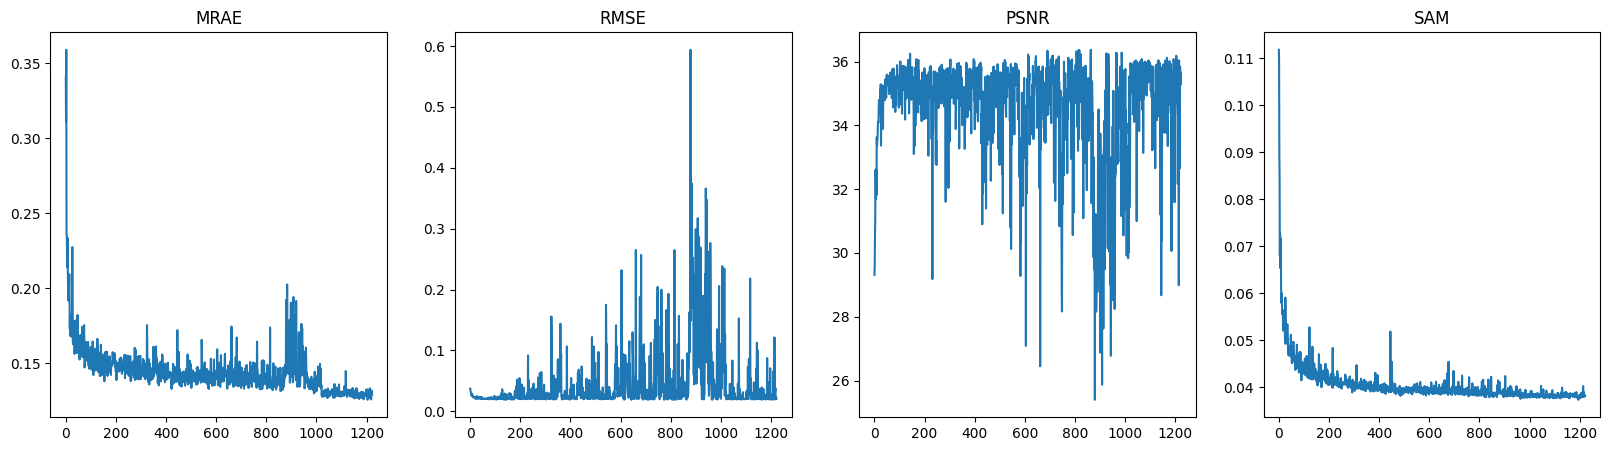

In [5]:
plt.figure(figsize=[20,5])
plt.subplot(1, 4, 1)
plt.plot(range(length), MRAE)
plt.title("MRAE")

plt.subplot(1, 4, 2)
plt.plot(range(length), RMSE)
plt.title("RMSE")

plt.subplot(1, 4, 3)
plt.plot(range(length), PSNR)
plt.title("PSNR")

plt.subplot(1, 4, 4)
plt.plot(range(length), SAM)
plt.title("SAM")


In [6]:
import scipy.io
import numpy as np
import cv2

Text(0.5, 1.0, 'Fake Generation')

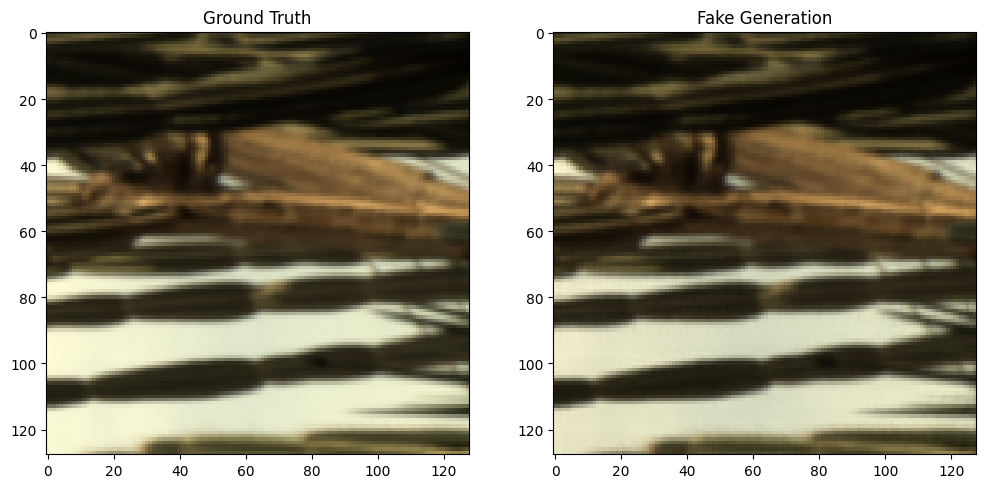

In [35]:
realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/SNCWGAN/'
fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGAN/'
# realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/D2GAN/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/D2GAN/'
# realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/SNCWGANNoNoise/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGANNoNoise/'
# realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/SNCWGANNoNoise/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGANNoNoise/'

name = '009.mat'

fake = scipy.io.loadmat(fakeroot + name)['rgb']
fake = (fake - fake.min()) / (fake.max()-fake.min())

real = scipy.io.loadmat(realroot + name)['rgb']
real = (real - real.min()) / (real.max()-real.min())

plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.imshow(real)
plt.title('Ground Truth')
plt.subplot(1, 2, 2)
plt.imshow(fake)
plt.title('Fake Generation')

In [36]:
import colour
image1_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(real))
image2_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(fake))
colour.delta_E(image1_lab, image2_lab).mean()

1.641513977019994

In [37]:
colour.delta_E(image1_lab, image2_lab, method="CIE 1976").mean()

2.2810430584457944

In [38]:
colour.delta_E(image1_lab, image2_lab, method="CIE 1976").std()

1.7160861966335736

1. Spatial Disc and Spectral Disc 
2. Heat maps of {MRAE, SAM , deltaE_1976 or 2000}
3. Diffusion Model

In [52]:
import seaborn as sns
def MRAE(x,y):
    return (x-y) ** 2
fake = scipy.io.loadmat(fakeroot + name)['cube']
# fake = (fake - fake.min()) / (fake.max()-fake.min())
real = scipy.io.loadmat(realroot + name)['cube']
# real = (real - real.min()) / (real.max()-real.min())

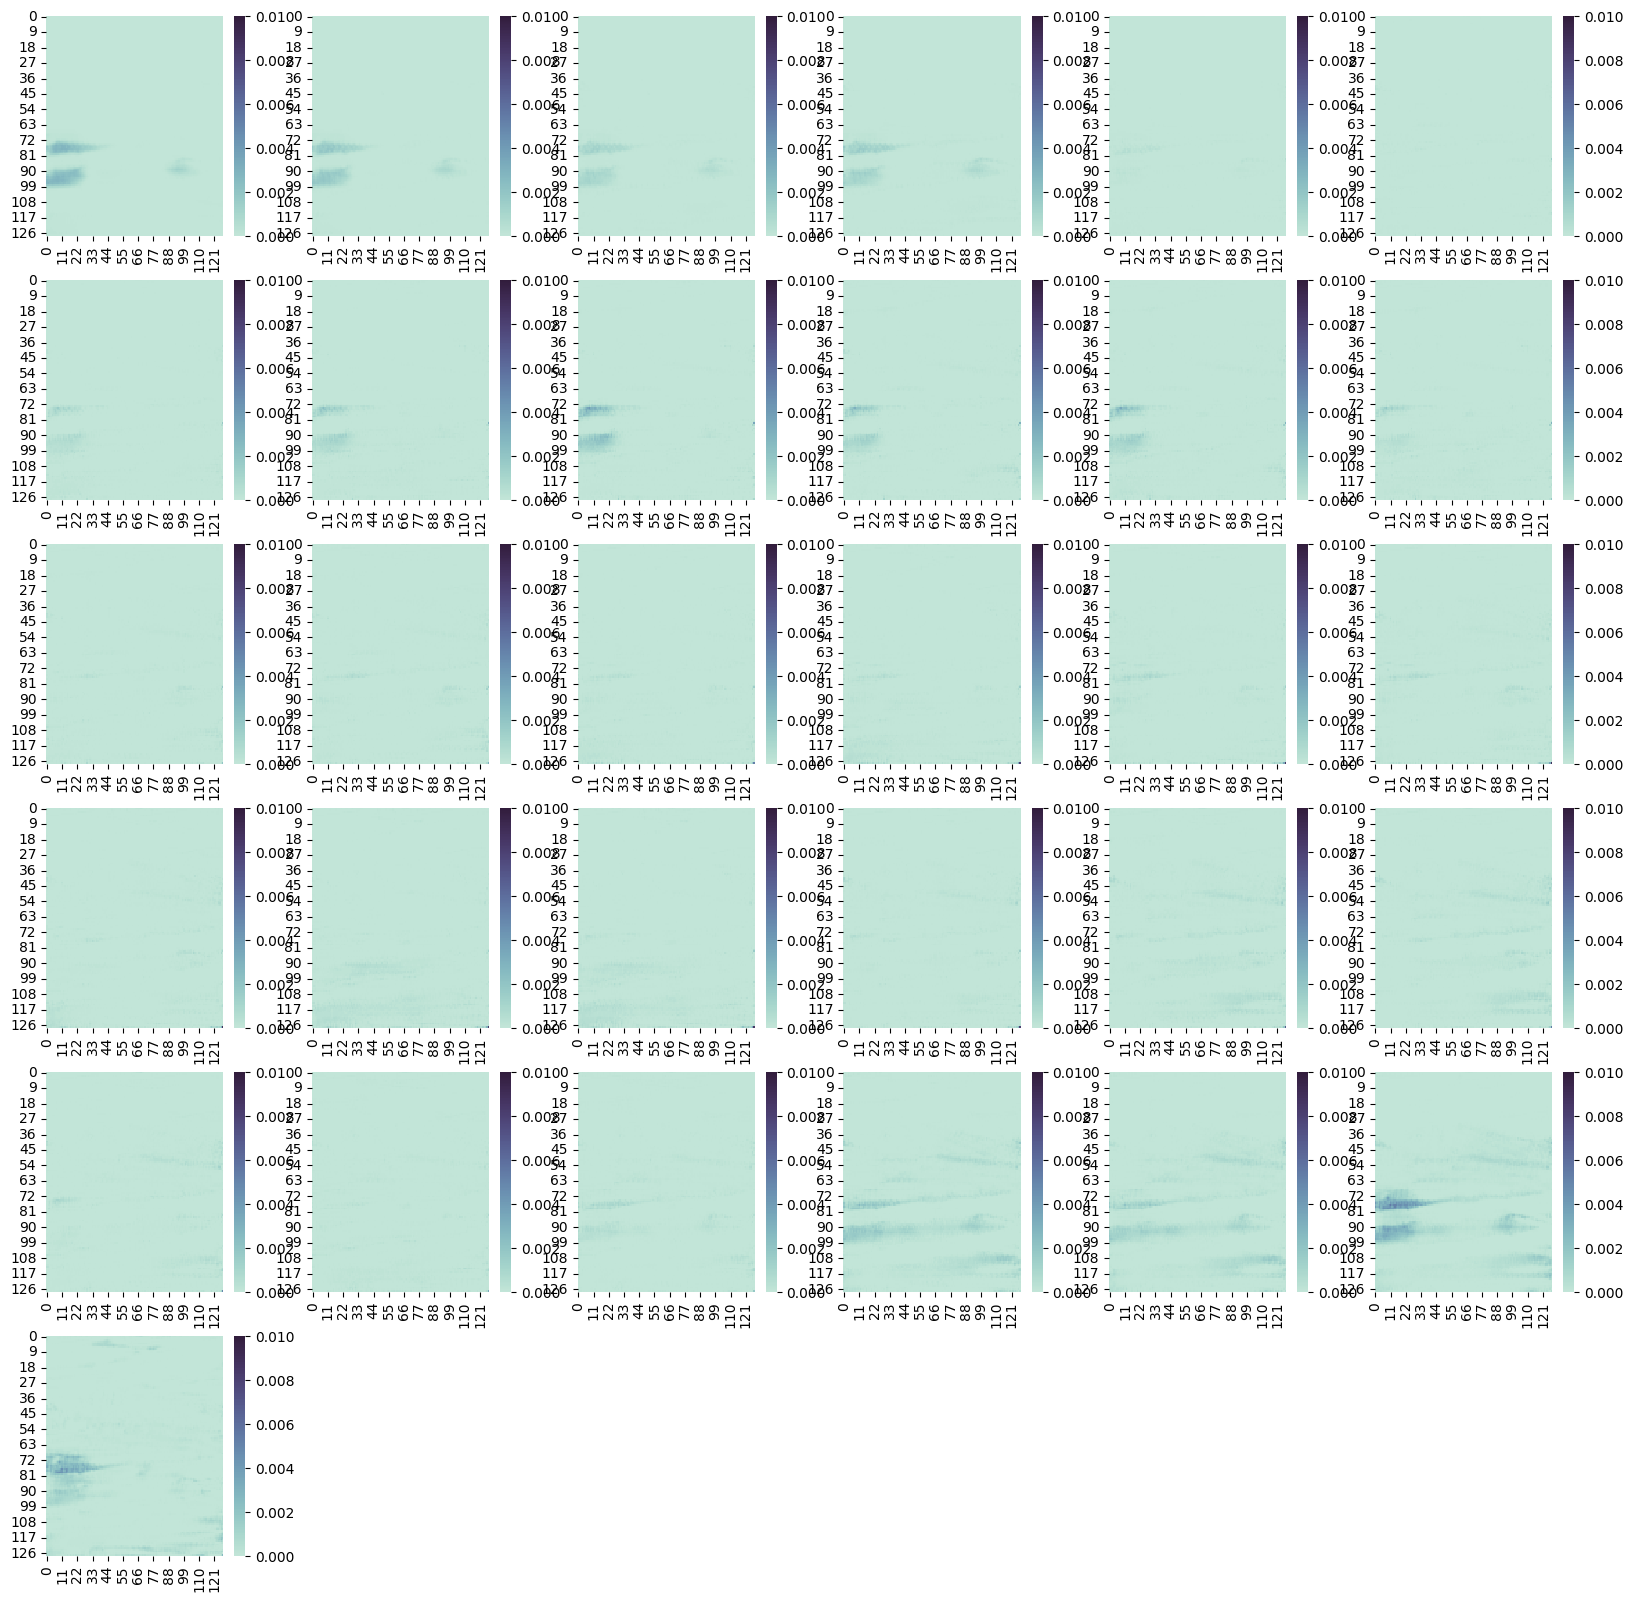

In [73]:
plt.figure(figsize=[20,20])
COLOR = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
for i in range(31):
    data = MRAE(real, fake)[:,:,i]
    plt.subplot(6, 6, i+1)
    sns.heatmap(data, vmin = 0, vmax = 0.01, cmap=COLOR)

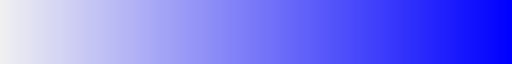

In [54]:
sns.color_palette("light:b", as_cmap=True)

In [40]:
print(MRAE(fake, real).mean())

6.12841e-05
